In [1]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from datasets import load_dataset

from classifier import *

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load clinical success annotation

In [3]:
# Load drug metadata from huggingface
ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")
drug_metadata = ds["train"].to_pandas()
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]

cs = load_dataset("tahoebio/Tahoe-100M", "cell_line_metadata")
cell_line_metadata = cs["train"].to_pandas()
cell_line_metadata.head()

# Create a mapping from cell line ID to organ
cell_line_to_organ = dict(zip(cell_line_metadata['Cell_ID_Cellosaur'], cell_line_metadata['Organ']))

# Create a list of all drug names vs all cell line names (Cell_ID_Cellosaur)
# First, get unique drug names and cell line IDs
unique_drugs = drug_metadata['drug'].unique()
unique_cell_lines = cell_line_metadata['Cell_ID_Cellosaur'].unique()

# Create a DataFrame with all combinations of drugs and cell lines
drug_cellline_combinations = []
for drug in unique_drugs:
    for cell_line in unique_cell_lines:
        drug_cellline_combinations.append({
            'drug': drug,
            'cell_line': cell_line,
            'drug-cell_line': f"{drug}_{cell_line}"
        })

# Convert to DataFrame
drug_cellline_df = pd.DataFrame(drug_cellline_combinations)

# Display the first few rows
print(f"Total combinations: {len(drug_cellline_df)}")
drug_cellline_df.head()
# Add organ information to the drug_cellline_df
drug_cellline_df['organ'] = drug_cellline_df['cell_line'].map(cell_line_to_organ)

# Create a drug_organ column by combining drug name and organ
drug_cellline_df['drug_organ'] = drug_cellline_df['drug'] + '_' + drug_cellline_df['organ']

drug_cellline_df


Total combinations: 38658


,drug,cell_line,drug-cell_line,organ,drug_organ
0,Talc,CVCL_0023,Talc_CVCL_0023,Lung,Talc_Lung
1,Talc,CVCL_1286,Talc_CVCL_1286,Lung,Talc_Lung
2,Talc,CVCL_1282,Talc_CVCL_1282,Vulva/Vagina,Talc_Vulva/Vagina
3,Talc,CVCL_1034,Talc_CVCL_1034,Skin,Talc_Skin
4,Talc,CVCL_2610,Talc_CVCL_2610,Skin,Talc_Skin
...,...,...,...,...,...
38653,γ-Oryzanol,CVCL_1547,γ-Oryzanol_CVCL_1547,Lung,γ-Oryzanol_Lung
38654,γ-Oryzanol,CVCL_1495,γ-Oryzanol_CVCL_1495,Lung,γ-Oryzanol_Lung
38655,γ-Oryzanol,CVCL_1531,γ-Oryzanol_CVCL_1531,Lung,γ-Oryzanol_Lung
38656,γ-Oryzanol,CVCL_1517,γ-Oryzanol_CVCL_1517,Lung,γ-Oryzanol_Lung


In [4]:
# Read approval tables
approved_df = pd.read_csv('data/drugs_organs_approved.csv', index_col=0)
tested_df = pd.read_csv('data/drugs_organs_tested.csv', index_col=0)

# Map from pubchem_id to drug name
pubchem_to_drug = dict(zip(drug_metadata['pubchem_cid_str'].astype(str), drug_metadata['drug']))
tested_df.index = tested_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))
approved_df.index = approved_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))

# Melt the dataframes to have drug column and organ column
long_approved_df = approved_df.melt(var_name='organ', value_name='is_approved', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_approved_df['drug_organ'] = long_approved_df['drug'] + '_' + long_approved_df['organ']

long_tested_df = tested_df.melt(var_name='organ', value_name='is_tested', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_tested_df['drug_organ'] = long_tested_df['drug'] + '_' + long_tested_df['organ']

# Filter to only tested combos
long_approved_df = long_approved_df[long_tested_df['is_tested'] == 1]

In [5]:
# adata_ldvae = sc.read_h5ad('ldvae_cellline_drug_aggr.h5ad')
# # Split the drugname_drugconc column into three separate columns
# drug_info = adata_ldvae.obs['drugname_drugconc'].str.strip('[]').str.extract(r'\(\'(.*?)\', (.*?), \'(.*?)\'\)')
# adata_ldvae.obs['drug_name'] = drug_info[0].str.strip()
# adata_ldvae.obs['drug_concentration'] = drug_info[1].astype(float)

# adata_ldvae.obs['organ'] = adata_ldvae.obs['cell_line'].map(cell_line_to_organ)
# adata_ldvae = adata_ldvae[adata_ldvae.obs['drug_concentration'] == 5]
# adata_ldvae.obs['drug_organ'] = adata_ldvae.obs['drug_name'] + '_' + adata_ldvae.obs['organ']

In [6]:
# common_drug_organ = np.intersect1d(adata_ldvae.obs['drug_organ'].unique(), long_approved_df['drug_organ'].unique())

# adata_ldvae_subset = adata_ldvae[adata_ldvae.obs['drug_organ'].isin(common_drug_organ)]

# X = adata_ldvae_subset.layers['mean_LDVAE_embedding'].copy()
# drug_organ_vec = adata_ldvae_subset.obs['drug_organ']
# y = long_approved_df.set_index('drug_organ').loc[drug_organ_vec]['is_approved']

# # Convert indices to drug-cell_line
# assert len(y) == X.shape[0]
# X = pd.DataFrame(X)
# adata_ldvae_subset.obs['drug-cell_line'] = adata_ldvae_subset.obs['drug_name'].astype(str) + '_' + adata_ldvae.obs['cell_line'].astype(str)
# y.index = adata_ldvae_subset.obs['drug-cell_line'].values
# X.index = adata_ldvae_subset.obs['drug-cell_line'].values


In [7]:
# drug_name = X.index.str.split('_CVCL_').str[0]
# cell_line_name = 'CVCL_' + X.index.str.split('_CVCL_').str[1]


## Load e-distance

In [51]:
edist = pd.read_csv('./data/tahoe_largest_edist_per_drug_cell_line_combo.csv')
edist['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[edist['cell_line']].Cell_ID_Cellosaur.values
edist['drug-cell_line'] = edist['drug_name'].astype(str) + '_' + edist['cell_line'].astype(str)
edist_df = edist.set_index('drug-cell_line')[['max_e_distance']]
edist_df = edist_df[edist_df.index.isin(drug_cellline_df['drug-cell_line'])]
edist_df['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[edist_df.index]['drug_organ']

edist_df.to_csv('./data_for_classifier/max_edist.csv')
edist_df.head()

,max_e_distance,drug_organ
drug-cell_line,,
Homoharringtonine_CVCL_1097,77.017775,Homoharringtonine_Skin
Homoharringtonine_CVCL_0218,77.017775,Homoharringtonine_Bowel
Harringtonine_CVCL_1478,70.707085,Harringtonine_Lung
Homoharringtonine_CVCL_0366,77.017775,Homoharringtonine_Liver
Homoharringtonine_CVCL_1285,77.017775,Homoharringtonine_Lung


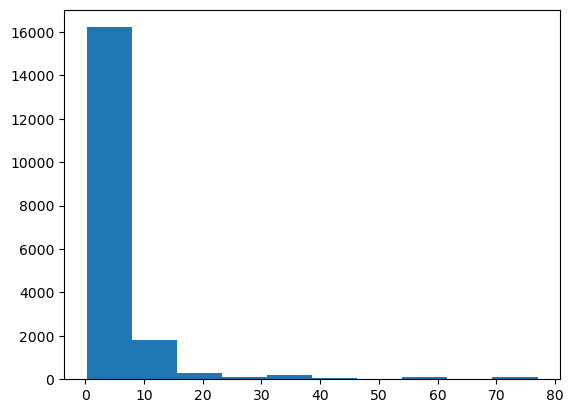

In [52]:
plt.hist(edist_df['max_e_distance']);

## Prep datasets

In [53]:
input_features = edist_df
outcomes = long_approved_df[['is_approved', 'drug_organ']]

common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

drug_organ_vec = input_features['drug_organ']
outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
outcomes.index = input_features.index

# Convert indices to drug-cell_line
assert len(y) == X.shape[0]
X = input_features.drop('drug_organ', axis=1)
y = outcomes.copy()

In [54]:
input_features.head()

,max_e_distance,drug_organ
drug-cell_line,,
Homoharringtonine_CVCL_1097,77.017775,Homoharringtonine_Skin
Homoharringtonine_CVCL_0366,77.017775,Homoharringtonine_Liver
Dinaciclib_CVCL_1495,59.208443,Dinaciclib_Lung
Homoharringtonine_CVCL_1381,77.017775,Homoharringtonine_Skin
Dinaciclib_CVCL_1478,59.208443,Dinaciclib_Lung


In [55]:
from classifier import *

## Test association

In [56]:
X_train, X_test, y_train, y_test = prepare_data(X,y)    

cols = X_train.columns
lr_model = train_linear_model(X_train[cols], y_train, alpha=0.001)    


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5687132597365621
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Model training Precision-Recall AUC: 0.2953
Model training ROC AUC: 0.5658
Regularization: alpha=0.001


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)



ROC AUC: 0.5353
Baseline ROC AUC: 0.5000
PR AUC: 0.2891
Baseline PR AUC: 1.0000

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.455348  1.731502e-13    0.634227   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -0.576475    -0.334222  

Number of significant coefficients (p < 0.05): 1 out of 1


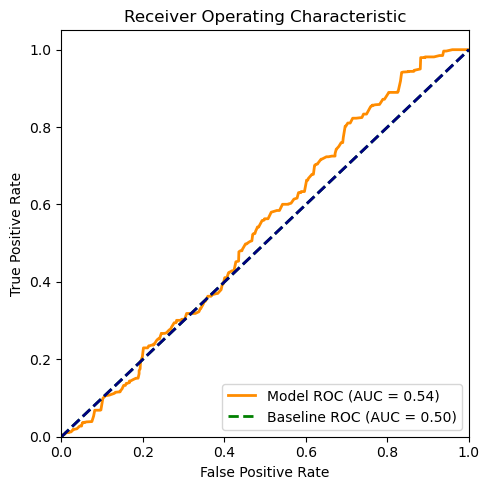

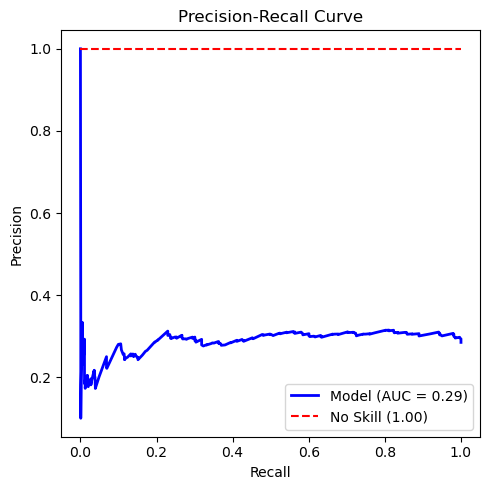

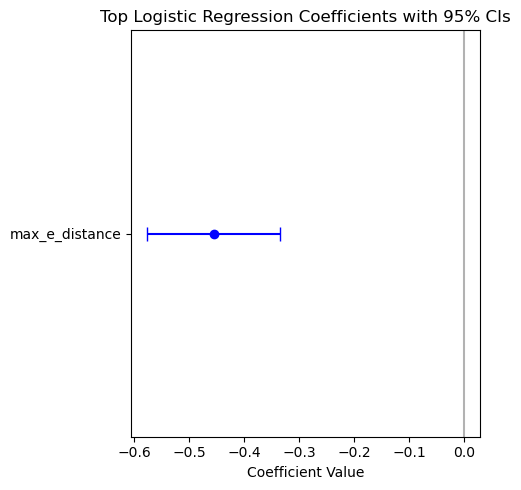

In [57]:
lr_pred, lr_prob = evaluate_model(lr_model, X_test[cols], y_test)    
coef_df = analyze_coefficients(lr_model, X_train[cols].columns)

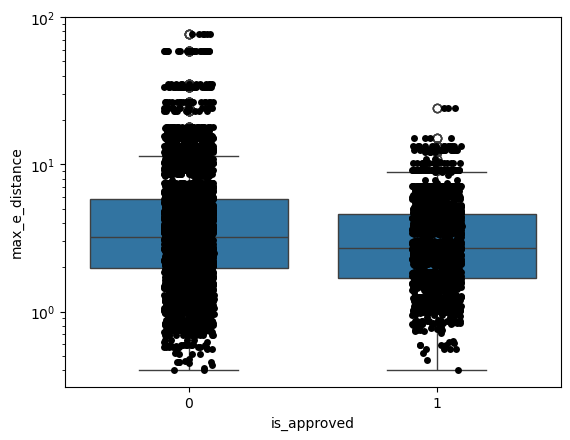

In [58]:
sns.boxplot(x = y['is_approved'], y=X['max_e_distance'])
sns.stripplot(x = y['is_approved'], y=X['max_e_distance'], color='black');
plt.yscale('log');

/tmp/ipykernel_2249228/1127730827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_features['organ'] = input_features['drug_organ'].str.split("_").str[1]
/tmp/ipykernel_2249228/1127730827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_features['is_approved'] = outcomes['is_approved'].values
/tmp/ipykernel_2249228/1127730827.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.st

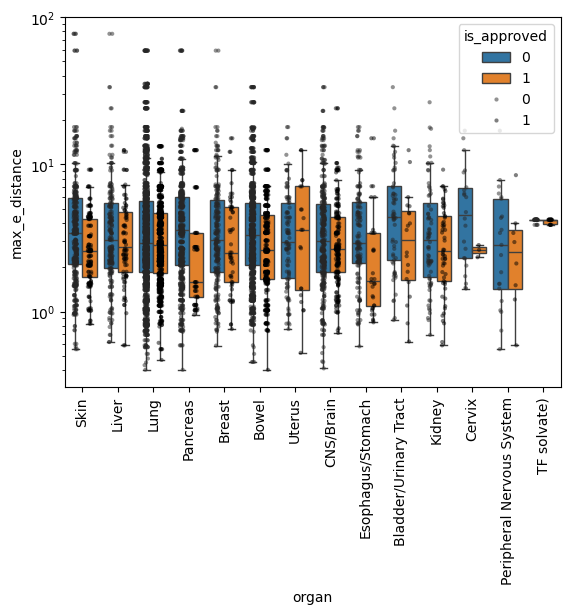

In [59]:
input_features['organ'] = input_features['drug_organ'].str.split("_").str[1]
input_features['is_approved'] = outcomes['is_approved'].values
# Create boxplot without fliers (outliers)
sns.boxplot(data=input_features, x='organ', y='max_e_distance', hue='is_approved', showfliers=False);
# Add stripplot to show individual data points
sns.stripplot(data=input_features, x='organ', y='max_e_distance', hue='is_approved', 
              dodge=True, size=3, color='black', alpha=0.5);
plt.yscale('log');
plt.xticks(rotation=90);